# What is the network learning?

* We can gain some intuition in what the network is learning
* Especially fruitful will turn out to look at the weights of the hidden layer



In [3]:
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))
### ---end of weird stuff

import h5py
import json
from keras.models import Model, model_from_json


def load_model(model_name):

    with open(model_name+".model.json", "rt") as f:
        model=model_from_json(f.read())
    model.load_weights(model_name+".weights.h5")
    
    with open(model_name+".vocabularies.json") as f:
        labels,vocab=json.load(f)
    
    return model,labels,vocab

model,labels,vocab=load_model("models/imdb_bow")
print(model)

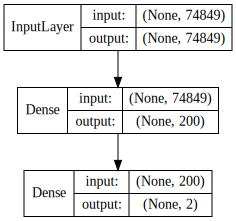

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True,show_layer_names=False).create(prog='dot', format='svg'))


* This is our model (watch out, Keras plots models from top to bottom)
* Hidden layer has 200 nodes with 74849 inputs each, one input for one word in the vocabulary
* We can also look at it the other way around: each word is assigned one weight for each hidden layer node
* So each word is seen by the network as a 200-dimensional vector
* But what are these vectors? What properties should they have? Let us find out!

* We want to visualize the 200-dimensional vectors
* t-SNE is one of the most popular methods for the task, producing a 2D projection
* it is an external program, so we need to run it on the command line
* one can get it here https://github.com/lvdmaaten/bhtsne/
* (takes quite a while to run)


In [5]:
import numpy 
import os
learned_weights=model.layers[1].get_weights()[0]
numpy.savetxt("imdb_vectors_in.txt",learned_weights) # save vectors to a file
# run tsne locally, input is an embedding matrix, output is an embedding matrix with reduced dimensions
os.system("python3 bhtsne/bhtsne.py --input imdb_vectors_in.txt --output imdb_vectors_out.txt")

0

In [6]:
m2d=numpy.loadtxt("imdb_vectors_out.txt") # read new vectors from a file
print("2D projected shape",m2d.shape)

2D projected shape (74849, 2)


Now we can plot the data in 2D, see what we get

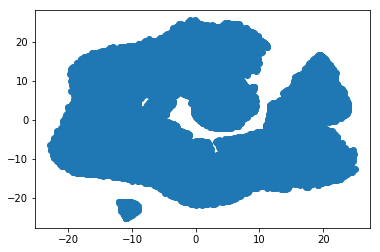

In [8]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(m2d[:,0],m2d[:,1]) #all rows, first column and all rows, second column
plt.show()


* We only need to plot few words, preferrably common ones
* TfidfVectorizer comes to the rescue, because it keeps track of word counts

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import json
import random
import numpy

with open("data/imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) #play it safe!
texts=[one_example["text"] for one_example in data]

vectorizer=CountVectorizer(vocabulary=vocab) #no binary this time, so we get counts
feature_matrix=vectorizer.fit_transform(texts)
print("Feature matrix shape", feature_matrix.shape)



Feature matrix shape (25000, 74849)


* Counts of all words can be obtained by summing all rows together:

In [10]:
word_counts=numpy.asarray(numpy.sum(feature_matrix,axis=0)).flatten()
print(word_counts)
print(word_counts.shape)

[ 93 300   1 ...   1   4   1]
(74849,)


In [11]:
# vocab is dictionary of {word : dimension}
words=sorted(vocab.items(),key=lambda word_idx:word_idx[1]) #Sort vocabulary dict by word index
# Sorted list of (word,dimension) pairs, sorted by dimension
# Now I can zip these with counts
words_by_count=sorted(zip(words,word_counts), key=lambda word_count:word_count[1],reverse=True)
print(words_by_count[:100]) #List of ((word,dimension),count) tuples, sorted by count, descending

[(('the', 66339), 336749), (('and', 3258), 164140), (('of', 46680), 145864), (('to', 67125), 135724), (('is', 34585), 107332), (('it', 34683), 96467), (('in', 33004), 93976), (('this', 66562), 76007), (('that', 66322), 73286), (('was', 72196), 48209), (('as', 4465), 46935), (('for', 25450), 44345), (('with', 73342), 44130), (('movie', 44147), 44047), (('but', 9881), 42623), (('film', 24536), 40159), (('you', 74324), 34267), (('on', 46916), 34202), (('not', 46050), 30632), (('he', 30211), 30155), (('are', 4124), 29438), (('his', 31095), 29376), (('have', 30118), 27731), (('be', 6334), 26957), (('one', 46932), 26795), (('all', 2662), 23985), (('at', 4753), 23516), (('they', 66474), 22915), (('by', 9962), 22548), (('an', 3167), 21564), (('who', 72904), 21441), (('so', 61380), 20614), (('from', 26180), 20499), (('like', 38755), 20281), (('there', 66432), 18865), (('her', 30646), 18424), (('or', 47142), 18007), (('just', 35787), 17774), (('about', 1277), 17375), (('out', 47449), 17113), (('

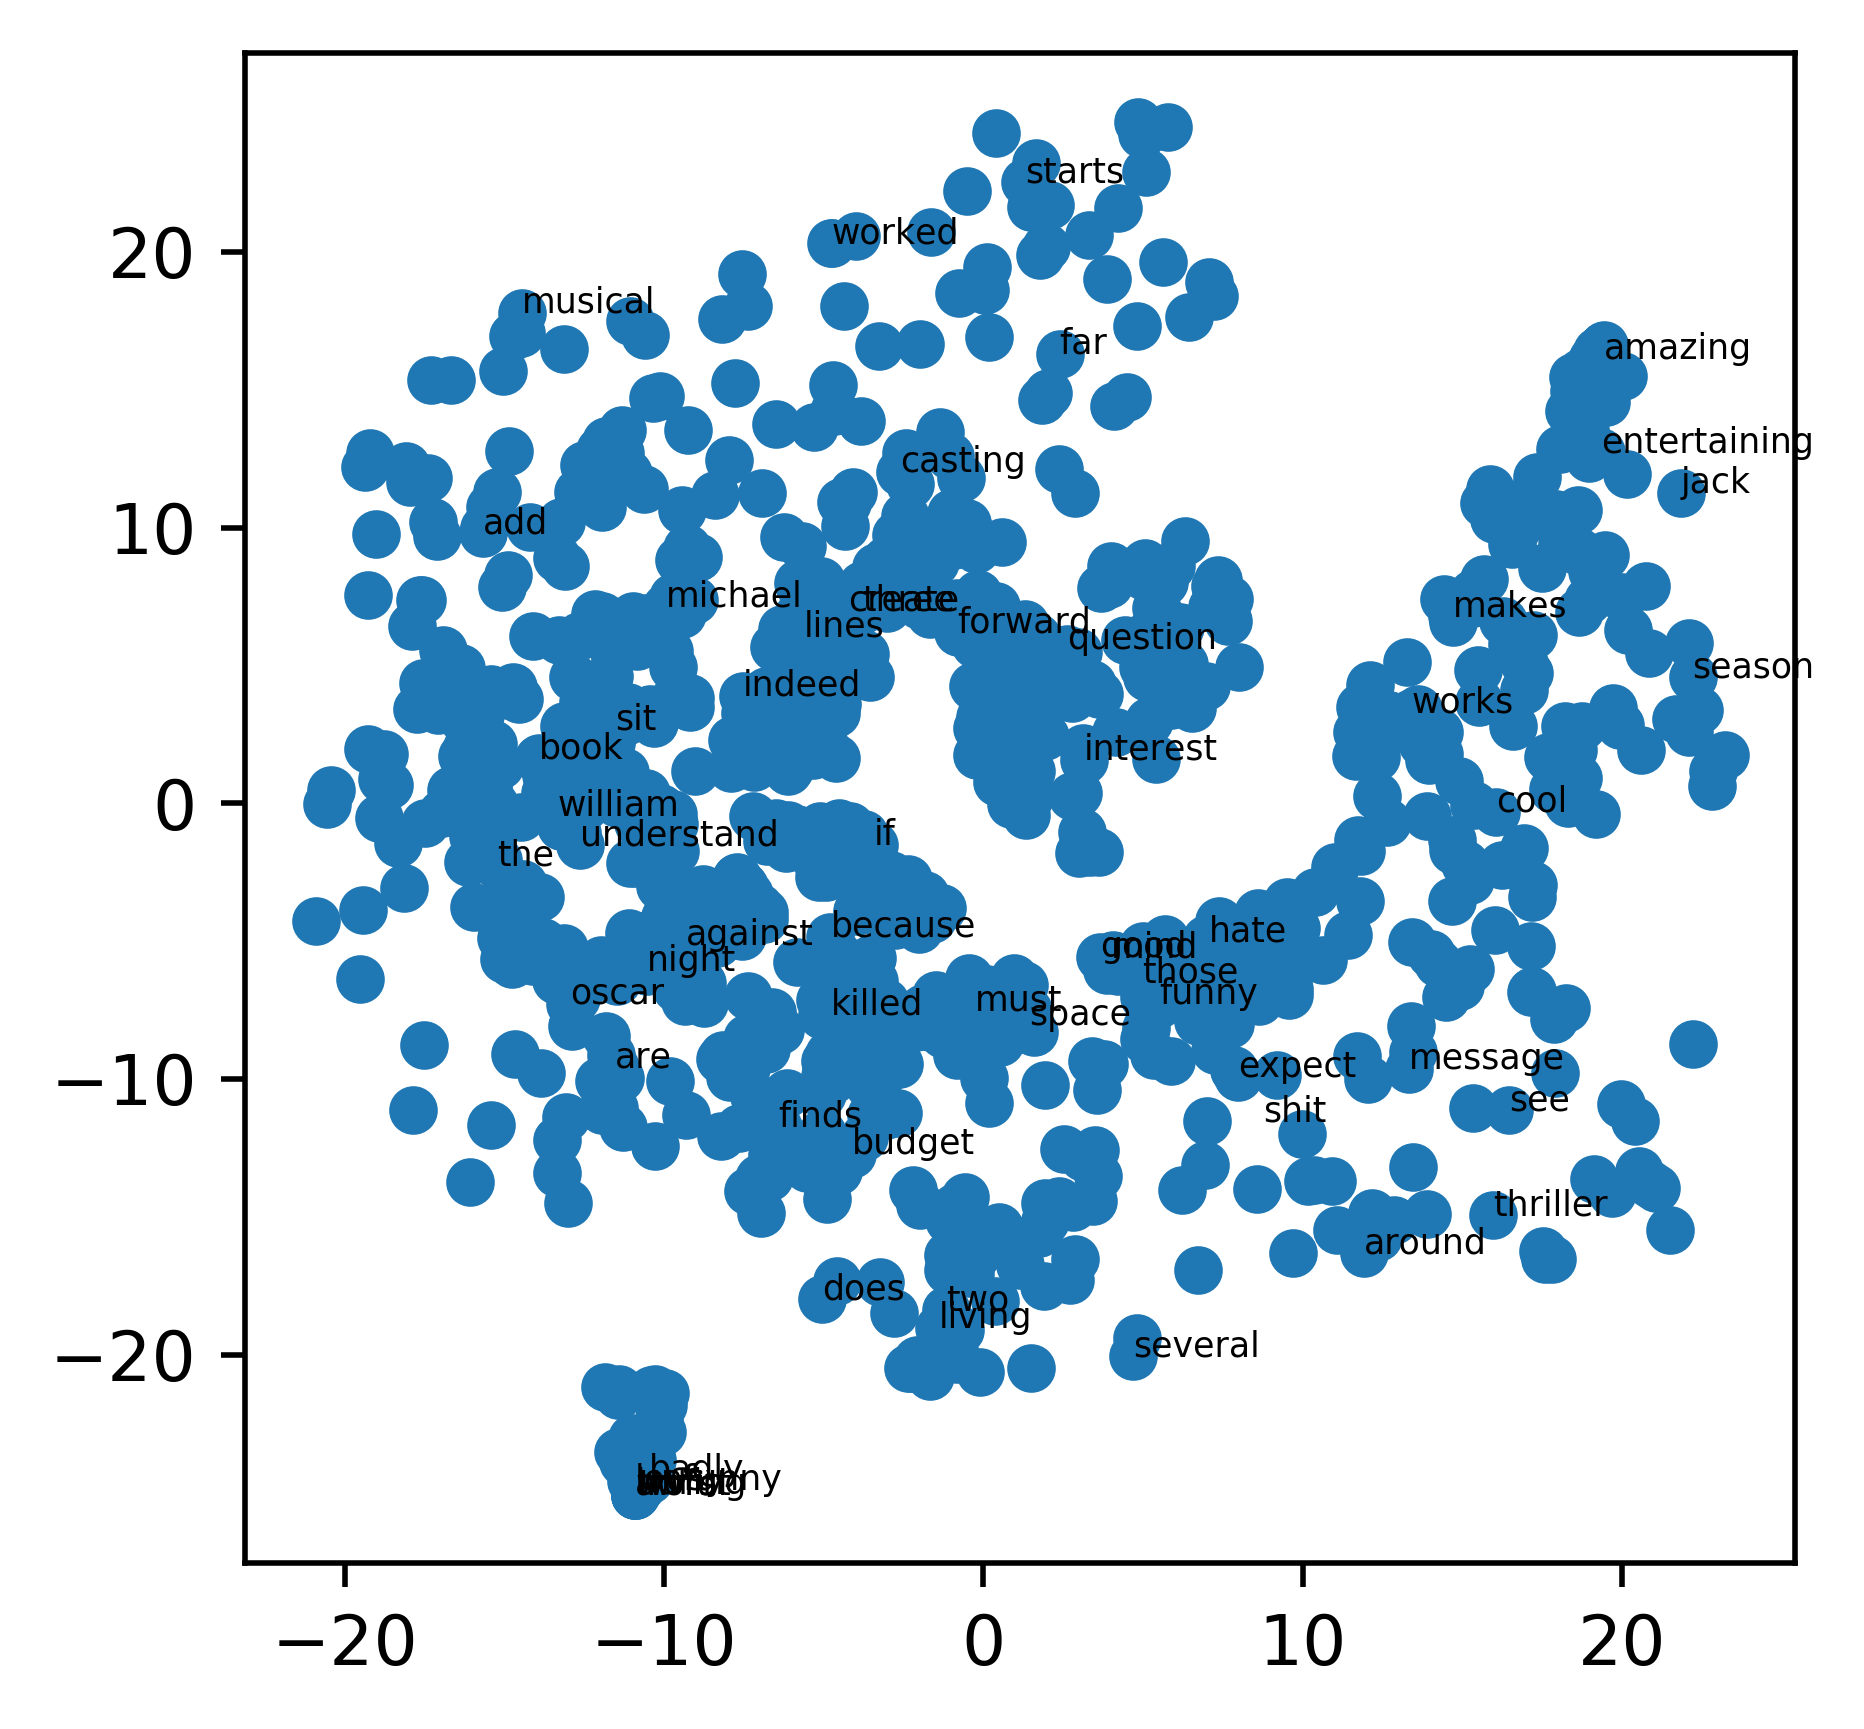

In [16]:
plt.figure(figsize=(4, 4), dpi=500)
to_plot=list(elem[0][1] for elem in words_by_count[:1000])
plt.scatter(m2d[to_plot,0],m2d[to_plot,1])
for ((word,idx),count) in words_by_count[:1000:20]:
    plt.text(m2d[idx][0],m2d[idx][1],word,size=5)
for wrd in "amazing,boring,good,shit,lousy,entertaining,unfunny,funny".split(","):
    idx=vocab[wrd]
    plt.text(m2d[idx][0],m2d[idx][1],wrd,size=5)
plt.show()

* Another way to inspect this space is to look at nearest neighbors of words
* For each word, we can list other words which are nearby in the space

This we can do, for example, with wvlib_light (get from github). We must first save the word vectors into a text file like such

```
<num words> <dimensionality>
word number number number ...
word number number number ...
...
```

In [13]:
words=sorted(vocab.items(),key=lambda item: item[1])
learned_weights=model.layers[1].get_weights()[0]
with open("models/imdb_bow_learned.vectors","wt") as f:
    print(*model.layers[1].get_weights()[0].shape,file=f)
    for word,weights in zip(words,learned_weights):
        print(word[0].replace(" ","_"),*weights,file=f)
    

```
python3 wvlib_light/nearest.py models/imdb_bow_learned.vectors

> excellent
0.99 refreshing             
0.99 underrated             
0.99 soylent                
0.99 hooked                 
0.99 woronov                
0.99 enjoyable              
0.99 wonderfully            
0.99 perfect                
0.99 great                  
0.99 rare                   


> boring
0.99 waste                  
0.99 forgettable            
0.99 mildly                 
0.99 poorly                 
0.99 disappointment         
0.99 awful                  
0.99 mst3k                  
0.99 unwatchable            
0.99 annoying               
0.99 disappointing          


> great
0.99 excellent              
0.98 reservations           
0.98 hooked                 
0.98 underrated             
0.98 incredible             
0.98 wonderfully            
0.98 refreshing             
0.98 enjoyable              
0.98 perfectly              
0.98 amazing                


> fun  
0.98 gem                    
0.98 captures               
0.97 troubled               
0.97 appreciated            
0.97 extraordinary          
0.97 surprisingly           
0.97 highly                 
0.97 enjoyed                
0.97 reeling                
0.97 unexpected             
```